In [1]:
# 導入必要的庫
import os
import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter, defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
import seaborn as sns
%matplotlib inline


In [2]:
# 定義資料目錄
data_dir = 'data/'  # 替換為您的數據目錄

# 定義類別和對應的標籤
categories = {'non': 0, 'swallow': 1}

# 列出所有音頻文件及其標籤
audio_files = []
labels = []

for category, label in categories.items():
    category_dir = os.path.join(data_dir, category)
    if not os.path.exists(category_dir):
        print(f"目錄 {category_dir} 不存在。請確認路徑正確。")
        continue
    for file in os.listdir(category_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(category_dir, file)
            audio_files.append(file_path)
            labels.append(label)

print(f"總音頻文件數量: {len(audio_files)}")
print(f"標籤分佈: {Counter(labels)} (非吞嚥: {categories['non']}, 吞嚥: {categories['swallow']})")


總音頻文件數量: 137
標籤分佈: Counter({0: 70, 1: 67}) (非吞嚥: 0, 吞嚥: 1)


In [3]:
# 定義音頻處理函數
def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def reduce_noise_signal(y, sr):
    if len(y) < int(0.5 * sr):
        noise_sample = y
    else:
        noise_sample = y[:int(0.5 * sr)]
    y_reduced = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
    return y_reduced

def split_audio(y, sr, segment_length=1.0, hop_length=0.5):
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    num_segments = 0

    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segments.append(y[start:end])
        num_segments += 1

    # 處理最後一個不足長度的片段
    remaining_samples = len(y) - (num_segments * hop_samples)
    if remaining_samples > 0 and remaining_samples < segment_samples:
        last_segment = y[-segment_samples:]
        padding = segment_samples - len(last_segment)
        last_segment_padded = np.pad(last_segment, (0, padding), mode='constant')
        segments.append(last_segment_padded)

    return segments

def extract_features(y, sr, n_mels=128, n_fft=2048, hop_length=512, fixed_length=130):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # 固定長度
    mel_spec_db = librosa.util.fix_length(mel_spec_db, size=fixed_length, axis=1)

    return mel_spec_db


In [4]:
# 初始化特徵和標籤列表
features = []
labels_processed = []

# 計數每個類別的片段數量
segment_counts = defaultdict(int)

# 定義固定的時間步數
fixed_length = 130

# 迭代處理每個音頻文件
for file_path, label in zip(audio_files, labels):
    # 讀取音頻
    y, sr = load_audio(file_path)

    # 去噪（可選）
    y = reduce_noise_signal(y, sr)

    # 分割音頻
    segments = split_audio(y, sr, segment_length=1.0, hop_length=0.5)

    # 如果分割後沒有片段，跳過該文件
    if not segments:
        continue

    # 對每個片段提取特徵
    for segment in segments:
        mel_spec = extract_features(segment, sr, fixed_length=fixed_length)
        mel_spec = mel_spec[..., np.newaxis]  # 添加channel維度 (128, 130, 1)
        features.append(mel_spec)
        labels_processed.append(label)
        segment_counts[label] += 1

print(f"總片段數量: {len(features)}")
print("每個類別的片段數量:", dict(segment_counts))

# 檢查所有特徵的形狀是否一致
for i, feature in enumerate(features):
    if feature.shape != (128, fixed_length, 1):
        print(f"片段 {i} 的形狀不一致: {feature.shape}")



總片段數量: 203
每個類別的片段數量: {0: 135, 1: 68}


In [5]:
# 將特徵和標籤轉換為NumPy數組
X = np.array(features)
y = np.array(labels_processed)
print(f"特徵形狀: {X.shape}")  # 應為 (samples, 128, 130, 1)
print(f"標籤形狀: {y.shape}")

# 將數值標準化到0-1之間
X = X / np.max(X)
print(f"標準化後的特徵形狀: {X.shape}")

# 調整數據形狀為 (samples, time_steps, height, width, channels)
# 這裡將時間步數設置為 fixed_length=130，height=128，width=1，channels=1
X = X.reshape((X.shape[0], fixed_length, 128, 1, 1))  # (samples, 130, 128, 1, 1)
print(f"重塑後的特徵形狀: {X.shape}")


特徵形狀: (203, 128, 130, 1)
標籤形狀: (203,)
標準化後的特徵形狀: (203, 128, 130, 1)
重塑後的特徵形狀: (203, 130, 128, 1, 1)


In [6]:
# 分割訓練集和測試集
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print(f"訓練集大小: {X_train.shape}")
    print(f"測試集大小: {X_test.shape}")
except ValueError as e:
    print("分層抽樣失敗，嘗試不使用 stratify")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"訓練集大小: {X_train.shape}")
    print(f"測試集大小: {X_test.shape}")

# 將標籤轉為類別
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f"訓練集標籤形狀: {y_train.shape}")
print(f"測試集標籤形狀: {y_test.shape}")

# 確保 y_train_labels 是一維的
y_train_labels = np.argmax(y_train, axis=1).astype(int).flatten()
print("y_train_labels shape:", y_train_labels.shape)  # 應為 (n_samples,)
print("y_train_labels:", y_train_labels[:10])  # 應為 [0, 1, 0, 0, ...]

# 獲取唯一類別
classes = np.unique(y_train_labels)
print("唯一類別:", classes)

# 計算類別權重
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
class_weights_dict = {i: weight for i, weight in zip(classes, class_weights)}
print("類別權重:", class_weights_dict)


訓練集大小: (162, 130, 128, 1, 1)
測試集大小: (41, 130, 128, 1, 1)
訓練集標籤形狀: (162, 2)
測試集標籤形狀: (41, 2)
y_train_labels shape: (162,)
y_train_labels: [1 1 1 0 1 0 0 0 0 0]
唯一類別: [0 1]
類別權重: {0: 0.75, 1: 1.5}


In [7]:
# 建立CNN + LSTM模型
def build_cnn_lstm(input_shape):
    """
    建立CNN + LSTM模型架構。

    參數:
    - input_shape: 輸入數據的形狀，例如 (time_steps, height, width, channels)

    返回:
    - model: 建立好的Keras模型
    """
    model = Sequential()

    # 第一個卷積層
    model.add(TimeDistributed(Conv2D(32, (3, 1), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 1), padding='same')))

    # 第二個卷積層
    model.add(TimeDistributed(Conv2D(64, (3, 1), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 1), padding='same')))

    # 第三個卷積層
    model.add(TimeDistributed(Conv2D(128, (3, 1), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 1), padding='same')))

    # TimeDistributed Flatten
    model.add(TimeDistributed(Flatten()))

    # LSTM層
    model.add(LSTM(128, return_sequences=False))

    # 全連接層
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # 輸出層
    model.add(Dense(2, activation='softmax'))

    return model


In [8]:
# 獲取輸入形狀（包括 time_steps）
input_shape = X_train.shape[1:]  # (130, 128, 1, 1)
print("輸入形狀:", input_shape)
# 建立模型
model = build_cnn_lstm(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


輸入形狀: (130, 128, 1, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 130, 128, 1, 32)  128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 130, 64, 1, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 130, 64, 1, 64)   6208      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 130, 32, 1, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (No

Epoch 1/30
6/6 [==============================] - 4s 472ms/step - loss: 0.7718 - accuracy: 0.5988 - val_loss: 0.6650 - val_accuracy: 0.6585
Epoch 2/30
6/6 [==============================] - 3s 424ms/step - loss: 0.6993 - accuracy: 0.5432 - val_loss: 0.7107 - val_accuracy: 0.4146
Epoch 3/30
6/6 [==============================] - 3s 430ms/step - loss: 0.7251 - accuracy: 0.5556 - val_loss: 0.6529 - val_accuracy: 0.6585
Epoch 4/30
6/6 [==============================] - 3s 440ms/step - loss: 0.7890 - accuracy: 0.5864 - val_loss: 0.6722 - val_accuracy: 0.6098
Epoch 5/30
6/6 [==============================] - 3s 431ms/step - loss: 0.7432 - accuracy: 0.5679 - val_loss: 0.7208 - val_accuracy: 0.3659
Epoch 6/30
6/6 [==============================] - 3s 430ms/step - loss: 0.7275 - accuracy: 0.4444 - val_loss: 0.6828 - val_accuracy: 0.5366
Epoch 7/30
6/6 [==============================] - 3s 437ms/step - loss: 0.6835 - accuracy: 0.5309 - val_loss: 0.6901 - val_accuracy: 0.5610
Epoch 8/30
6/6 [====

C:\Users\bymin\AppData\Local\Temp\ipykernel_30504\1910507994.py:27: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_30504\1910507994.py:27: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_30504\1910507994.py:27: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_30504\1910507994.py:27: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_30504\1910507994.py:27: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_30504\1910507994.py:27: UserWarning: Glyph 30906 (\

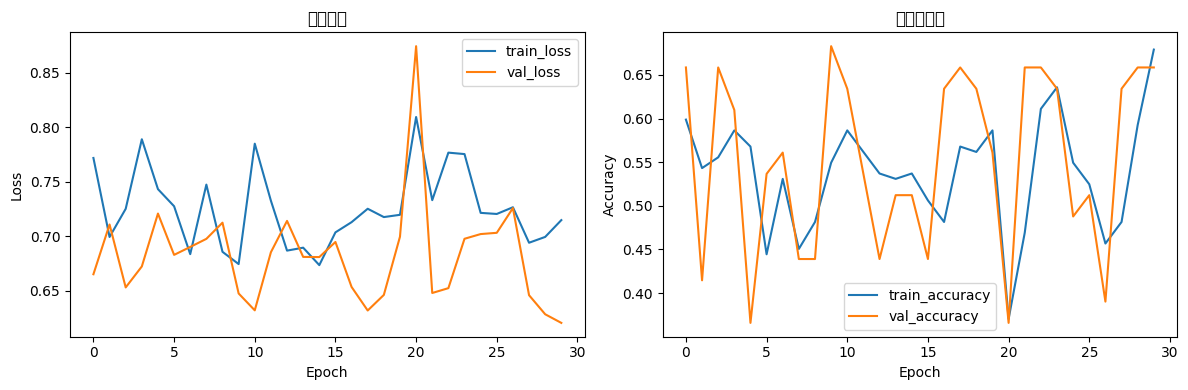

In [9]:
# 訓練模型，並使用類別權重
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)

# 繪製訓練過程
plt.figure(figsize=(12, 4))

# 繪製損失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('損失曲線')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 繪製準確率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('準確率曲線')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# 評估模型在測試集上的表現
loss, accuracy = model.evaluate(X_test, y_test)
print(f"測試集損失: {loss:.4f}")
print(f"測試集準確率: {accuracy * 100:.2f}%")


2/2 [==============================] - 0s 85ms/step - loss: 0.6203 - accuracy: 0.6585
測試集損失: 0.6203
測試集準確率: 65.85%


2/2 [==============================] - 1s 86ms/step
混淆矩陣:
[[27  0]
 [14  0]]

分類報告:
              precision    recall  f1-score   support

 Non Swallow       0.66      1.00      0.79        27
     Swallow       0.00      0.00      0.00        14

    accuracy                           0.66        41
   macro avg       0.33      0.50      0.40        41
weighted avg       0.43      0.66      0.52        41



c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


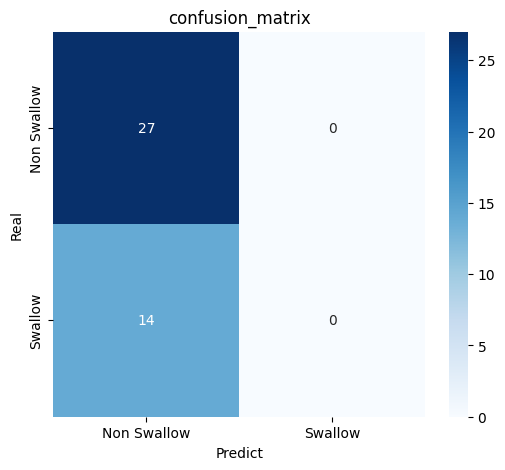

In [11]:
# 預測測試集
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred_classes)
print("混淆矩陣:")
print(cm)

# 分類報告
print("\n分類報告:")
print(classification_report(y_true, y_pred_classes, target_names=['Non Swallow', 'Swallow']))

# 可視化混淆矩陣
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Swallow', 'Swallow'],
            yticklabels=['Non Swallow', 'Swallow'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('confusion_matrix')
plt.show()


In [12]:
# 定義滑動窗口預測函數
def sliding_window_predict(y, sr, model, window_length=1.0, hop_length=0.5, threshold=0.5, fixed_length=130):
    """
    使用滑動窗口方法對整個音頻進行預測，並計數吞嚥聲音的數量。

    參數:
    - y: 音頻信號
    - sr: 採樣率
    - model: 已訓練的CNN + LSTM模型
    - window_length: 窗口長度（秒）
    - hop_length: 窗口跳步長度（秒）
    - threshold: 判斷為吞嚥聲音的概率閾值
    - fixed_length: 固定的時間步數（帧數）

    返回:
    - count: 吞嚥聲音的數量
    """
    window_samples = int(window_length * sr)
    hop_samples = int(hop_length * sr)
    predictions = []

    for start in range(0, len(y) - window_samples + 1, hop_samples):
        end = start + window_samples
        window = y[start:end]
        mel_spec = extract_features(window, sr, fixed_length=fixed_length)
        mel_spec = mel_spec[..., np.newaxis]  # (128, 130, 1)

        # 處理可能的NaN或極小值
        if np.max(mel_spec) == 0:
            mel_spec = mel_spec + 1e-6
        mel_spec = mel_spec / np.max(mel_spec)  # 標準化

        # 轉置以符合時間步長 (time_steps, height, width, channels)
        mel_spec = mel_spec.transpose(1, 0, 2)  # (130, 128, 1)

        # 調整形狀為 (samples, time_steps, height, width, channels)
        mel_spec = mel_spec.reshape(1, fixed_length, mel_spec.shape[1], 1, mel_spec.shape[2])  # (1, 130, 128, 1, 1)

        pred = model.predict(mel_spec, verbose=0)
        predictions.append(pred[0][1])  # 吞嚥聲音的概率

    # 根據閾值判斷吞嚥事件
    swallowing_events = [i for i, prob in enumerate(predictions) if prob > threshold]

    # 去除重疊的事件
    min_distance = int(window_length / hop_length * 1)  # 最小間隔，根據實際情況調整
    final_events = []
    last_event = -min_distance
    for event in swallowing_events:
        if event - last_event > min_distance:
            final_events.append(event)
            last_event = event

    return len(final_events)


In [13]:
# 定義新的音頻文件路徑
new_audio_path = '音檔\測試RSST.wav'  # 替換為您的音頻文件路徑

# 檢查文件是否存在並進行預測
if not os.path.exists(new_audio_path):
    print(f"音頻文件 {new_audio_path} 不存在。請確認路徑正確。")
else:
    # 讀取新的音頻文件
    y_new, sr_new = load_audio(new_audio_path)

    # 可選：去噪
    # y_new = reduce_noise_signal(y_new, sr_new)

    # 使用滑動窗口方法進行預測和計數
    count = sliding_window_predict(y_new, sr_new, model, window_length=1.0, hop_length=0.5, threshold=0.5, fixed_length=130)
    print(f"吞嚥聲音數量: {count}")


吞嚥聲音數量: 0
